In [1]:
from pimports import *

In [12]:
# Download model and prose code
# Prose helper functions are not available through pip. We can clone to local dir instead
!git clone https://github.com/tbepler/prose.git prose
!wget http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
!unzip saved_models.zip -d prose/
sys.path.insert(-1, os.path.join(os.getcwd(), 'prose/'))

Cloning into 'prose'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 1), reused 23 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), 232.45 KiB | 4.30 MiB/s, done.
--2022-11-19 16:02:36--  http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
Resolving bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)... 128.30.48.147
Connecting to bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)|128.30.48.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581846360 (555M) [application/zip]
Saving to: ‘saved_models.zip’

saved_models.zip    100%[===================>] 554.89M  27.8MB/s    in 20s     

2022-11-19 16:02:57 (27.1 MB/s) - ‘saved_models.zip’ saved [581846360/581846360]

Archive:  saved_models.zip
   creating: prose/saved_models/
  inflating: prose/saved_models/prose_dlm_3x1024.sav  
  inflating: p

In [13]:
import h5py
import torch

from prose.alphabets import Uniprot21
import prose.fasta as fasta

In [14]:
from prose.models.multitask import ProSEMT
model = ProSEMT.load_pretrained()

In [15]:
model.eval()

ProSEMT(
  (embedding): SkipLSTM(
    (dropout): Dropout(p=0, inplace=False)
    (layers): ModuleList(
      (0): LSTM(21, 1024, batch_first=True, bidirectional=True)
      (1): LSTM(2048, 1024, batch_first=True, bidirectional=True)
      (2): LSTM(2048, 1024, batch_first=True, bidirectional=True)
    )
    (proj): Linear(in_features=6165, out_features=100, bias=True)
    (cloze): Linear(in_features=6165, out_features=21, bias=True)
  )
  (scop_predict): OrdinalRegression(
    (compare): L1()
  )
  (cmap_predict): BilinearContactMap(
    (linear): Linear(in_features=6165, out_features=6165, bias=True)
  )
)

In [22]:
alphabet = Uniprot21()

def embed_sequence(x):
    x = x.upper()
    # convert to alphabet index
    if not isinstance(x, bytes):
        x = x.encode()
    x = alphabet.encode(x)
    x = torch.from_numpy(x)

    # embed the sequence
    with torch.no_grad():
        x = x.long().unsqueeze(0)
        z = model.transform(x)
        z = z.squeeze(0)
        z = z.cpu().numpy()
        return z

In [23]:
test_seq = 'GWKSVFRKAKKVGKTVGGLALDHYLG'
embed_sequence(test_seq)

array([[ 0.        ,  0.        ,  0.        , ..., -0.09498271,
         0.04543836, -0.00095042],
       [ 0.        ,  0.        ,  0.        , ..., -0.03352331,
         0.00997906, -0.00886245],
       [ 0.        ,  0.        ,  0.        , ..., -0.04075152,
         0.03099523, -0.01077104],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.054672  ,
         0.03112976,  0.0277304 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.02287393,
         0.00230813,  0.01178937],
       [ 0.        ,  0.        ,  0.        , ..., -0.00913513,
         0.01913887,  0.01769974]], dtype=float32)

In [24]:
train_df = pd.read_csv('data/acp/train_data.csv')
train_df

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1
...,...,...
1373,LLKLLKWLLKLLK,0
1374,GFKDWIKGAAKKLIKTVAANIANQ,0
1375,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,0
1376,FISAIASFLGKFL,1


In [25]:
train_df['embeddings'] = train_df['sequences'].map(embed_sequence)

In [31]:
train_df['embeddings'].values[0].mean(0)

array([ 0.        ,  0.6       ,  0.        , ...,  0.1556936 ,
       -0.16820548, -0.18965332], dtype=float32)

In [32]:
train_df['mean_embeddings'] = train_df['embeddings'].map(lambda x: x.mean(0))
train_df['max_embeddings'] = train_df['embeddings'].map(lambda x: x.max(0))
train_df['sum_embeddings'] = train_df['embeddings'].map(lambda x: x.sum(0))

In [33]:
train_df

,sequences,label,embeddings,mean_embeddings,max_embeddings,sum_embeddings
0,RRWWRRWRRW,0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[0.07692308, 0.03846154, 0.0, 0.03846154, 0.0,...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 5.0, 1.0, ..."
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.23529412, 0.0, 0.0, 0.029411765, 0.0, 0.058...","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[8.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 4.0, 1.0, ..."
3,GLFDVIKKVAAVIGGL,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[0.125, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.187...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, ..."
4,VAKLLAKLAKKVL,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.23076923, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
1373,LLKLLKWLLKLLK,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1374,GFKDWIKGAAKKLIKTVAANIANQ,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[0.20833333, 0.0, 0.083333336, 0.041666668, 0....","[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[5.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, ..."
1375,ESEFDRQEYEECKRQCMQLETSGQMRRCVSQCDKRFEEDIDWSKYDNQE,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[0.0, 0.10204082, 0.020408163, 0.10204082, 0.0...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.0, 5.0, 1.0, 5.0, 4.0, 6.0, 9.0, 1.0, 0.0, ..."
1376,FISAIASFLGKFL,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.15384616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [46]:
mean_embeddings = pd.DataFrame(train_df['mean_embeddings'].tolist())
max_embeddings = pd.DataFrame(train_df['max_embeddings'].tolist())
sum_embeddings = pd.DataFrame(train_df['sum_embeddings'].tolist())

In [75]:
all_embeddings = mean_embeddings.merge(max_embeddings, left_index=True, right_index=True).merge(sum_embeddings, left_index=True, right_index=True)
all_embeddings

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,6155,6156,6157,6158,6159,6160,6161,6162,6163,6164
0,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.548113,0.887380,-0.011494,0.271127,0.018067,-0.564391,0.086048,1.556936,-1.682055,-1.896533
1,0.076923,0.038462,0.000000,0.038462,0.000000,0.000000,0.000000,0.192308,0.038462,0.000000,...,-7.972939,9.072073,-0.096385,4.018457,3.480438,-3.530303,-1.416183,-1.577047,1.123186,0.039732
2,0.235294,0.000000,0.000000,0.029412,0.000000,0.058824,0.000000,0.117647,0.029412,0.029412,...,-10.085312,14.277732,-0.013697,5.943668,5.035316,-4.763993,-1.879369,0.970733,2.752564,-0.118959
3,0.125000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.187500,0.000000,0.125000,...,-6.287031,2.116524,-0.038926,0.721899,2.538266,0.089579,0.830452,-0.038556,0.892718,-0.347309
4,0.230769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.101768,2.404987,-0.172026,0.754230,1.023387,0.035288,1.041382,-0.748091,-0.334926,-0.022781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.044391,3.585590,0.035471,0.821086,0.415504,-1.159784,0.905641,-1.765311,-0.081168,-0.566072
1374,0.208333,0.000000,0.083333,0.041667,0.000000,0.041667,0.000000,0.083333,0.000000,0.125000,...,-9.114376,7.999720,-0.213530,5.889935,5.887403,-3.913526,-11.102267,-2.716248,3.324497,-1.516388
1375,0.000000,0.102041,0.020408,0.102041,0.081633,0.122449,0.183673,0.020408,0.000000,0.020408,...,4.462688,-6.183336,-0.036329,2.522436,5.417280,-7.545887,4.008225,-8.707508,2.155240,-14.134404
1376,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.153846,...,-3.003110,1.373076,-0.040675,1.128679,0.634764,-0.311402,-0.376997,-0.699875,-0.326243,0.302838


# Lets try to do a random forest with this data

In [81]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1_000, 
                             max_depth=10,
                             random_state=42)

In [82]:
from sklearn.model_selection import train_test_split

X, y = all_embeddings, train_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [83]:
# Fit RandomForestClassifier
rfc.fit(X_train, y_train)
# Predict the test set labels
y_pred = rfc.predict(X_test)

In [84]:
# # Import `tree` module
# from sklearn import tree

# features = X.columns.values # The name of each column
# classes = ['0', '1'] # The name of each class
# # You can also use low, medium and high risks in the same order instead
# # classes = ['low risk', 'medium risk', 'high risk']

# for estimator in rfc.estimators_:
#     print(estimator)
#     plt.figure(figsize=(12,6))
#     tree.plot_tree(estimator,
#                    feature_names=features,
#                    class_names=classes,
#                    fontsize=8, 
#                    filled=True, 
#                    rounded=True)
#     plt.show()

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       150
           1       0.70      0.66      0.68       126

    accuracy                           0.72       276
   macro avg       0.72      0.71      0.71       276
weighted avg       0.72      0.72      0.72       276



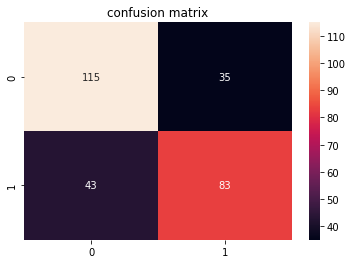

In [85]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('confusion matrix')

print(classification_report(y_test,y_pred))

# Results as shown above are just meh.
#### Next steps:
* Try the other model `from prose.models.lstm import SkipLSTM`
* Try to combine the features from the other model
* Try something other than random forest
* Understand what the `.mean/max/sum` are supposed to do